In [426]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [427]:
!pip install tensorflow


[notice] A new release of pip available: 22.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [428]:

%pip install tensorflow

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

%pip install dowhy
from dowhy import CausalModel


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [429]:
#Chargement et nettoyages les données
import pandas as pd
df = pd.read_csv(
    r"D:\ProjetSyn\AirQualityUCI_with_quality_24h.csv",
    sep=",", decimal=".", header=0,
    encoding="utf-8"
)

import numpy as np
# Remplacer -200 par NaN (valeurs manquantes)
df.replace(-200, np.nan, inplace=True)

# Supprimer les lignes contenant des valeurs NaN
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

df = df.drop(columns=['NMHC(GT)'])

# Convertir Date et Time en format datetime
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
df['Time'] = pd.to_timedelta(df['Time'])
df['Datetime'] = df['Date'] + df['Time']
df.set_index('Datetime', inplace=True)      
df.drop(columns=['Date', 'Time'], inplace=True)
df.head()  



,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,NO2_24h_mean,Qualite_Air_24h
Datetime,,,,,,,,,,,,,,
2004-03-10 18:00:00,2.6,1360.00,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.60,48.875001,0.757754,113.000000,Mauvais
2004-03-10 19:00:00,2.0,1292.25,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.30,47.700000,0.725487,102.500000,Mauvais
2004-03-10 20:00:00,2.2,1402.00,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.90,53.975000,0.750239,106.333333,Mauvais
2004-03-10 21:00:00,2.2,1375.50,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.00,60.000000,0.786713,110.250000,Mauvais
2004-03-10 22:00:00,1.6,1272.25,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.15,59.575001,0.788794,111.400000,Mauvais


In [430]:
df.describe()

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,NO2_24h_mean
count,827.000000,827.000000,827.000000,827.000000,827.000000,827.000000,827.000000,827.000000,827.000000,827.000000,827.000000,827.000000,827.000000
mean,2.353567,1207.741838,10.772367,965.983777,143.501814,963.178053,100.259976,1600.506550,1045.691052,15.599859,49.049557,0.831851,74.135933
std,1.409496,241.826753,7.417127,266.413137,81.829717,265.906153,31.493823,302.290036,400.130277,4.825555,15.266995,0.178506,44.727772
min,0.300000,752.500000,0.542781,447.500000,12.000000,461.250000,19.000000,955.000000,263.000000,6.275000,14.900000,0.402317,-189.208333
25%,1.300000,1016.875000,4.804320,753.500000,81.000000,768.875000,78.500000,1369.125000,759.500000,11.875000,36.700000,0.718949,72.916667
50%,2.000000,1172.000000,9.125831,944.250000,128.000000,920.000000,99.000000,1556.250000,1009.000000,15.025000,49.550000,0.817693,83.208333
75%,3.100000,1380.250000,14.803204,1142.375000,187.000000,1131.000000,122.000000,1783.375000,1319.750000,18.350000,60.525001,0.927524,94.562500
max,8.100000,2039.750000,39.202340,1754.250000,478.000000,1934.500000,196.000000,2679.000000,2358.500000,30.000000,83.224998,1.485238,113.791667



[notice] A new release of pip available: 22.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


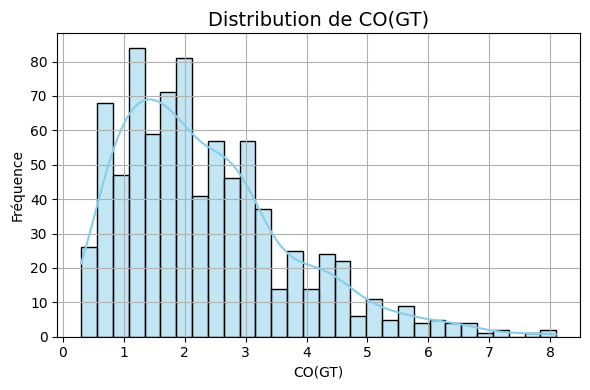

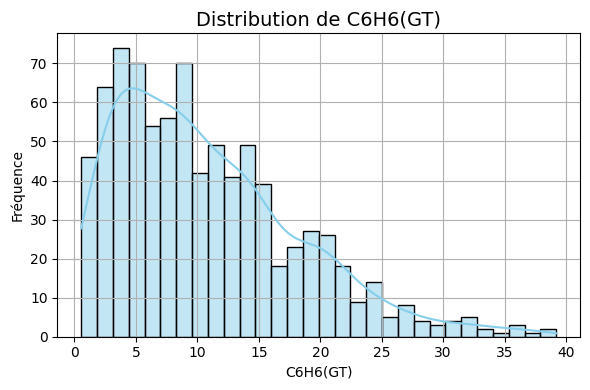

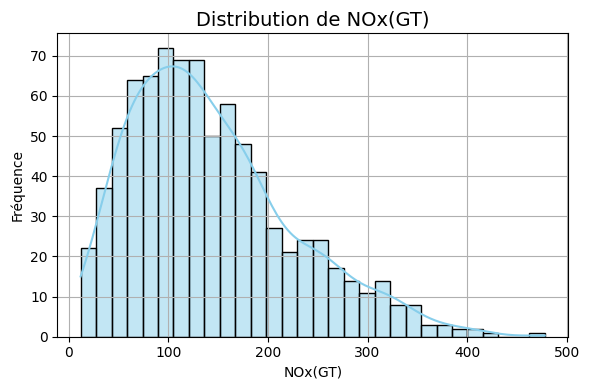

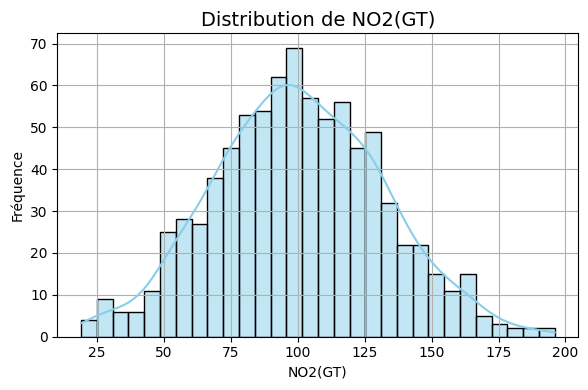

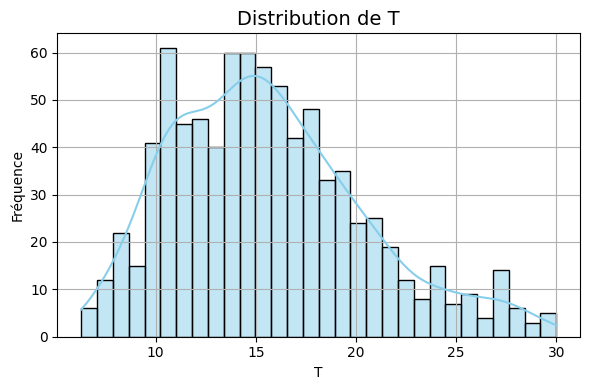

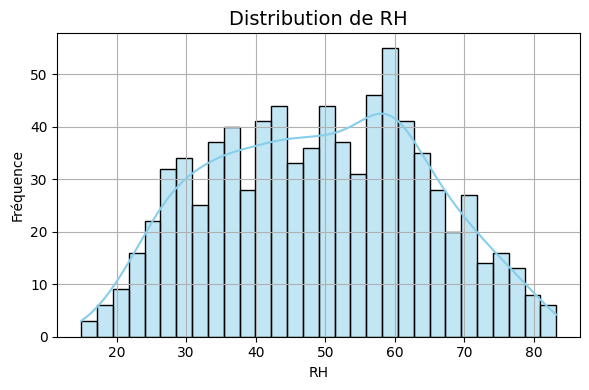

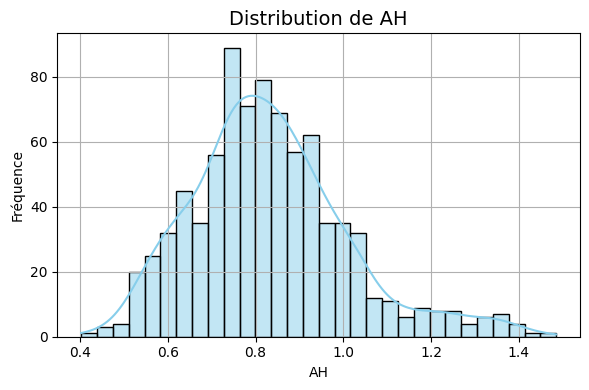

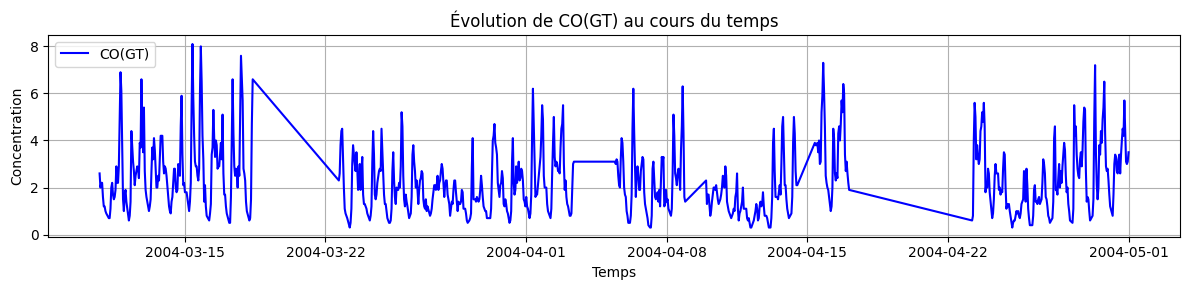

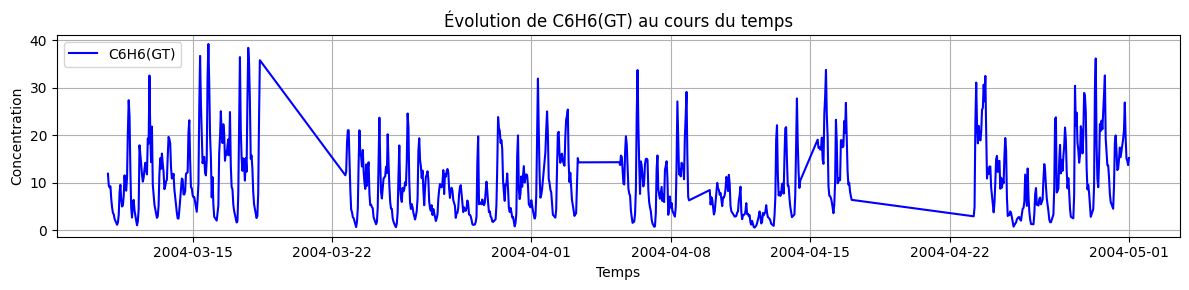

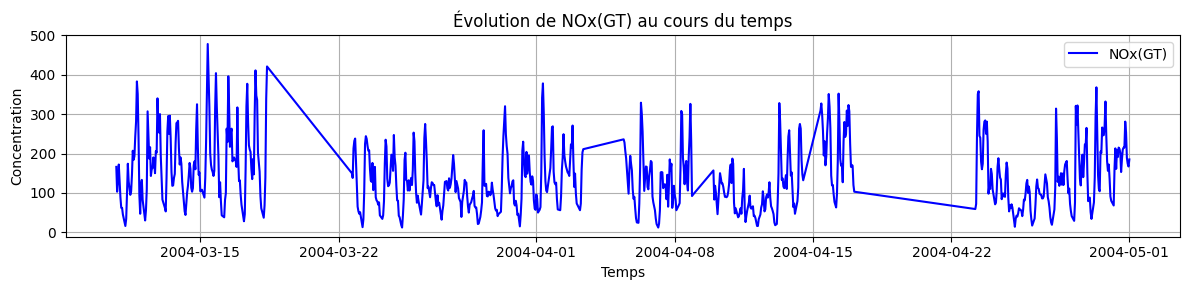

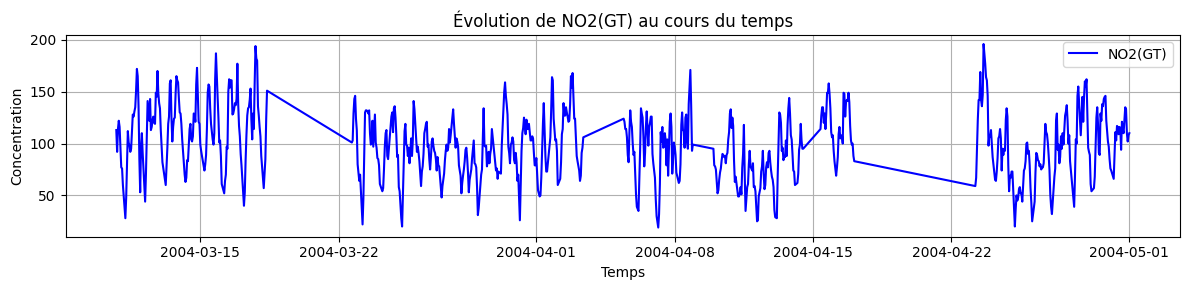

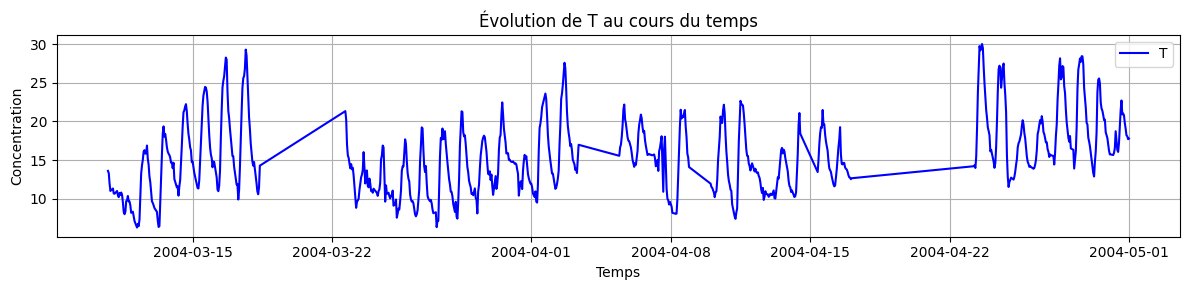

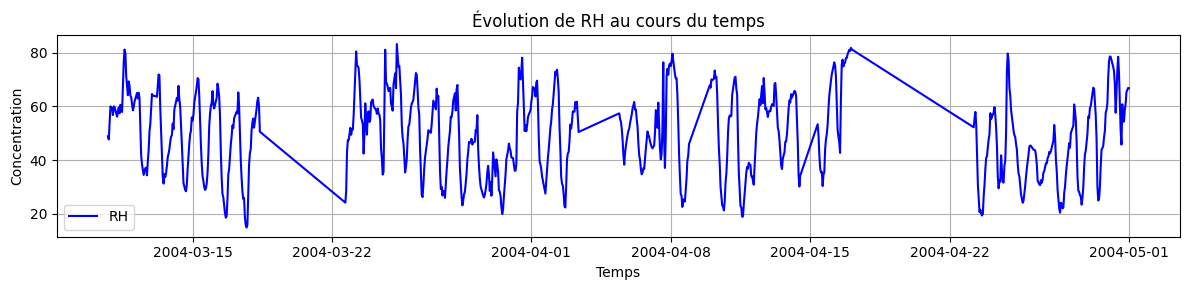

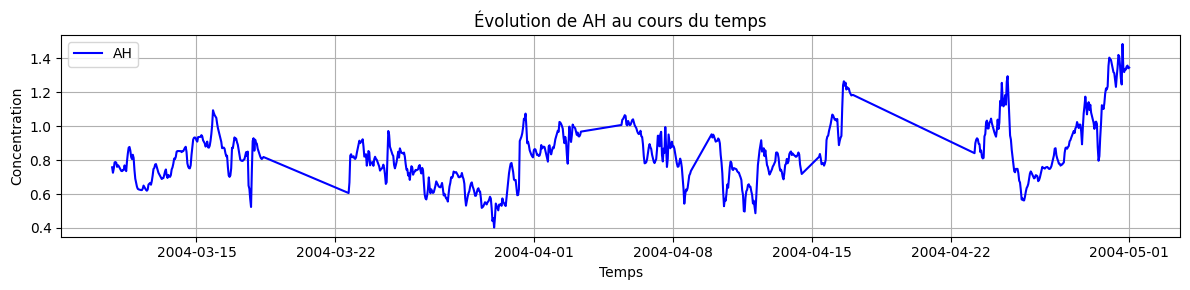

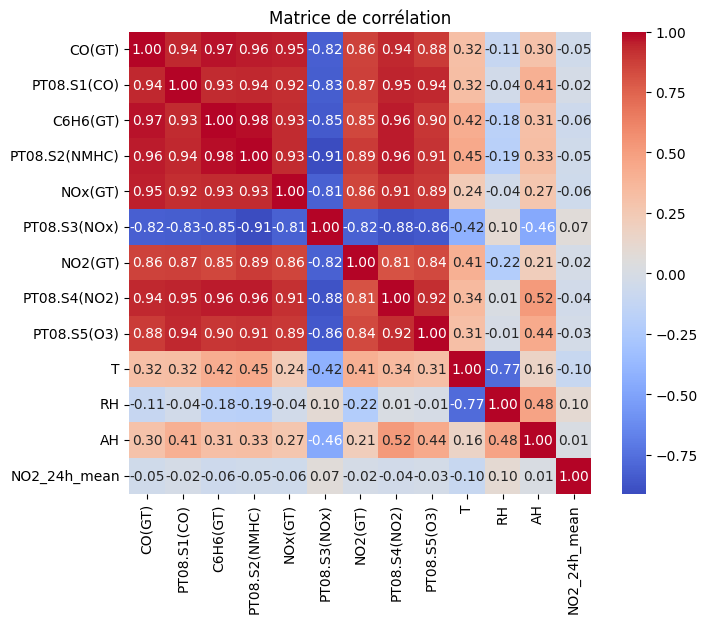

In [431]:

# Analyse exploratoire des données
%pip install seaborn
import matplotlib.pyplot as plt
import seaborn as sns
polluants = ['CO(GT)','C6H6(GT)', 'NOx(GT)', 'NO2(GT)', 'T','RH','AH']
# Visualiser la distribution de CO(GT)
#plt.figure(figsize=(8, 6))
#sns.histplot(df['CO(GT)'], bins=30, kde=True)
#plt.title('Distribution de CO(GT)')
#plt.xlabel('CO(GT)')
#plt.ylabel('Fréquence')
#plt.show()
# Histogramme pour chaque polluant
for col in polluants:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col].dropna(), bins=30, kde=True, color='skyblue')
    plt.title(f'Distribution de {col}', fontsize=14)
    plt.xlabel(col)
    plt.ylabel('Fréquence')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Création d'un graphique de type série temporelle pour visualiser l'évolution de CO(GT) dans le temps
#plt.figure(figsize=(12, 3))
#plt.plot(df.index, df['CO(GT)'], color='blue')
#plt.title('Évolution de CO(GT) au cours du temps')
#plt.xlabel('Temps')
#plt.ylabel('CO(GT)')
#plt.grid()
#plt.show()
for col in polluants:
    plt.figure(figsize=(12, 3))
    plt.plot(df.index, df[col], label=col, color='blue')
    plt.title(f"Évolution de {col} au cours du temps")
    plt.xlabel("Temps")
    plt.ylabel("Concentration")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Matrice de corrélation (colonnes numériques uniquement)
plt.figure(figsize=(8, 6))
sns.heatmap(df.select_dtypes(include=[np.number]).corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Matrice de corrélation')
plt.show()



In [304]:
features = ['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)','NO2_24h_mean']
target= features.index('NO2_24h_mean')
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features])

In [432]:

import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def create_sequences(data, target_col, seq_len=24):
    """
    Convertir le DataFrame en séquences à fenêtres glissantes.
    """
    X, y = [], []
    target = data[target_col].values
    features = data.values
    for i in range(len(data) - seq_len):
        X.append(features[i:i+seq_len])
        y.append(target[i+seq_len])
    return np.array(X), np.array(y)

def evaluate(y_true, y_pred):
    return {
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred),
        "R2": r2_score(y_true, y_pred),
        "MAPE": np.mean(np.abs((y_true - y_pred) / (y_true))) * 100
    }
    #rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    #mae = mean_absolute_error(y_true, y_pred)
    #r2 = r2_score(y_true, y_pred)
    #mape = np.mean(np.abs((y_true - y_pred) / (y_true))) * 100
    #return {"RMSE": rmse, "MAE": mae, "R2": r2, "MAPE": mape}


In [433]:
%pip install torch

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Modèle TCN
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super().__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size]

class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, dilation, padding, dropout=0.2):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class TCN(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=3, dropout=0.2):
        super().__init__()
        layers = []
        for i in range(len(num_channels)):
            dilation = 2 ** i
            in_ch = num_inputs if i == 0 else num_channels[i-1]
            out_ch = num_channels[i]
            layers.append(TemporalBlock(in_ch, out_ch, kernel_size, stride=1,
                                        dilation=dilation, padding=(kernel_size-1)*dilation,
                                        dropout=dropout))
        self.network = nn.Sequential(*layers)
        self.fc = nn.Linear(num_channels[-1], 1)

    def forward(self, x):
        # x: [batch, seq, features] -> [batch, features, seq]
        x = x.transpose(1, 2)
        y = self.network(x)
        y = y[:, :, -1]  # Dernier pas de temps
        return self.fc(y)


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [434]:
# ---------------------- Transformer -------------------
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, d_model=64, nhead=4, num_layers=2, dropout=0.1):
        super().__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead,
                                                   dropout=dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer(x)
        x = x[:, -1, :]  # Dernier pas de temps
        return self.fc(x)


In [435]:
#Entraînement
def train_model(model, train_loader, val_loader, epochs=10, lr=1e-3, device="cpu"):
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb).squeeze()
            loss = criterion(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb).squeeze()
                val_loss += criterion(pred, yb).item()
        print(f"Epoch {epoch+1}/{epochs}, Val Loss: {val_loss/len(val_loader):.4f}")
    return model


In [436]:
# Validation croisée

from sklearn.model_selection import KFold

def cross_validate_model(ModelClass, X, y, k=5, epochs=10, device="cpu", **model_kwargs):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    metrics_list = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        print(f"\n--- Fold {fold + 1}/{k} ---")
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                                torch.tensor(y_train, dtype=torch.float32)),
                                  batch_size=32, shuffle=True)
        val_loader = DataLoader(TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                                              torch.tensor(y_val, dtype=torch.float32)),
                                batch_size=32)

        model = ModelClass(**model_kwargs)
        trained_model = train_model(model, train_loader, val_loader, device=device, epochs=epochs)

        with torch.no_grad():
            y_pred = trained_model(torch.tensor(X_val, dtype=torch.float32).to(device)).squeeze().cpu().numpy()
        metrics = evaluate(y_val, y_pred)
        metrics_list.append(metrics)

    avg_metrics = pd.DataFrame(metrics_list).mean().to_dict()
    return avg_metrics

In [437]:
# Préparer les séquences
target = "CO(GT)"
seq_len = 24
device = "cuda" if torch.cuda.is_available() else "cpu"

# Conserver uniquement les colonnes numériques pour la création des séquences
df_numeric = df.select_dtypes(include=[np.number])
X, y = create_sequences(df_numeric, target, seq_len=seq_len)

# ========== Hyperparamètres testés ==========
tcn_fn = lambda: TCN(num_inputs=X.shape[2], num_channels=[32, 32], kernel_size=3, dropout=0.2)
trans_fn = lambda: TimeSeriesTransformer(input_dim=X.shape[2], d_model=64, nhead=4, num_layers=2, dropout=0.1)

# ========== Évaluation croisée ==========
print("\nValidation croisée du modèle TCN...")
tcn_results = cross_validate_model(tcn_fn, X, y, k=3, epochs=10)
print("Résultats TCN:", tcn_results)

print("\nValidation croisée du modèle Transformer...")
transformer_results = cross_validate_model(trans_fn, X, y, k=3, epochs=10)
print("Résultats Transformer:", transformer_results)

# ========== Comparaison ==========
print("\nComparaison Finale des modèles :")
comparison = pd.DataFrame({
    "Modèle": ["TCN", "Transformer"],
    "RMSE": [tcn_results["RMSE"], transformer_results["RMSE"]],
    "MAE": [tcn_results["MAE"], transformer_results["MAE"]],
    "R2": [tcn_results["R2"], transformer_results["R2"]],
    "MAPE (%)": [tcn_results["MAPE"], transformer_results["MAPE"]]
    })
print(comparison.round(4))
# ========================
# Évaluation TCN
# ========================
#print("\n##### TCN #####")
#tcn_results = cross_validate_model(
#        TCN,
#        X, y,
#        k=5,
#        epochs=10,
#        device=device,
#        num_inputs=X.shape[2],
#        num_channels=[32, 32, 32]
#    )
#print("Résultats TCN:", tcn_results)

# ========================
# Évaluation Transformer
# ========================
#print("\n##### Transformer #####")
#transformer_results = cross_validate_model(
#        TimeSeriesTransformer,
#        X, y,
#        k=5,
#        epochs=10,
#        device=device,
#        input_dim=X.shape[2]
#    )
#print("Résultats Transformer:", transformer_results)

# Séparation train/val/test
#n = len(X)
#train_size = int(n*0.7)
#val_size = int(n*0.15)

#X_train, y_train = X[:train_size], y[:train_size]
#X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
#X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

# Création des ensembles de données Torch
#train_loader = DataLoader(TensorDataset(torch.tensor(X_train.astype(np.float32), dtype=torch.float32),
#                                        torch.tensor(y_train.astype(np.float32), dtype=torch.float32)),
#                          batch_size=32, shuffle=True)
#val_loader = DataLoader(TensorDataset(torch.tensor(X_val.astype(np.float32), dtype=torch.float32),
#                                      torch.tensor(y_val.astype(np.float32), dtype=torch.float32)),
#                        batch_size=32)

# 1. Entraîner le modèle TCN sur l’ensemble d’apprentissage
#tcn = TCN(num_inputs=X.shape[2], num_channels=[32, 32,32])
#tcn = train_model(tcn, train_loader, val_loader, epochs=10, device="cpu")

# 2. Entraîner le modèle Transformer sur l’ensemble d’apprentissage
#transformer = TimeSeriesTransformer(input_dim=X.shape[2])
#transformer = train_model(transformer, train_loader, val_loader, epochs=10, device="cpu")

# Évaluer les performances du modèle sur l’ensemble de test
#def predict(model, X):
#    model.eval()
#    with torch.no_grad():
#        return model(torch.tensor(X, dtype=torch.float32)).squeeze().numpy()

#y_pred_tcn = predict(tcn, X_test)
#y_pred_trans = predict(transformer, X_test)

#results = pd.DataFrame([
#    {"Model": "TCN", **evaluate(y_test, y_pred_tcn)},
#    {"Model": "Transformer", **evaluate(y_test, y_pred_trans)}
#])
#print("\n Résultats comparatifs :")
#print(results.round(4))
#print("TCN:", evaluate(y_test, y_pred_tcn))
#print("Transformer:", evaluate(y_test, y_pred_trans))





Validation croisée du modèle TCN...

--- Fold 1/3 ---
Epoch 1/10, Val Loss: 1530.3077
Epoch 2/10, Val Loss: 540.6548
Epoch 3/10, Val Loss: 320.9605
Epoch 4/10, Val Loss: 284.5153
Epoch 5/10, Val Loss: 218.4722
Epoch 6/10, Val Loss: 174.9168
Epoch 7/10, Val Loss: 148.1966
Epoch 8/10, Val Loss: 183.0141
Epoch 9/10, Val Loss: 217.8760
Epoch 10/10, Val Loss: 171.4392

--- Fold 2/3 ---
Epoch 1/10, Val Loss: 249.8536
Epoch 2/10, Val Loss: 113.5412
Epoch 3/10, Val Loss: 88.3309
Epoch 4/10, Val Loss: 86.9254
Epoch 5/10, Val Loss: 72.3084
Epoch 6/10, Val Loss: 62.2028
Epoch 7/10, Val Loss: 56.7224
Epoch 8/10, Val Loss: 54.9610
Epoch 9/10, Val Loss: 58.9500
Epoch 10/10, Val Loss: 54.7454

--- Fold 3/3 ---
Epoch 1/10, Val Loss: 4218.8874
Epoch 2/10, Val Loss: 1672.8656
Epoch 3/10, Val Loss: 586.4180
Epoch 4/10, Val Loss: 436.9532
Epoch 5/10, Val Loss: 468.5251
Epoch 6/10, Val Loss: 162.4412
Epoch 7/10, Val Loss: 185.3269
Epoch 8/10, Val Loss: 137.4812
Epoch 9/10, Val Loss: 185.8271
Epoch 10/10, 

In [438]:
%pip install tigramite

import matplotlib.pyplot as plt
from tigramite.data_processing import DataFrame as TigramiteDF
from tigramite.independence_tests.parcorr import ParCorr
from tigramite.pcmci import PCMCI
import tigramite.plotting as tp

# DÉCOUVERTE CAUSALE : PCMCI

def run_pcmci(df, maxlag=6, alpha=0.05):
    """
    Exécuter la découverte causale PCMCI sur un DataFrame de séries temporelles.
    """
    data = df.values
    var_names = list(df.columns)
    
    dataframe = TigramiteDF(data, var_names=var_names)
    parcorr = ParCorr(significance='analytic')
    pcmci = PCMCI(dataframe=dataframe, cond_ind_test=parcorr)

    results = pcmci.run_pcmci(tau_max=maxlag, pc_alpha=alpha)
    pcmci.print_significant_links(
        p_matrix=results['p_matrix'],
        val_matrix=results['val_matrix'],
        alpha_level=alpha
    )

    # Il faut fournir tau_min et tau_max
    graph = pcmci.get_graph_from_pmatrix(
        p_matrix=results['p_matrix'],
        alpha_level=alpha,
        tau_min=1,
        tau_max=maxlag
    )

    # Générer et afficher le graphe résultant
    tp.plot_graph(
        graph,
        var_names=var_names,
        figsize=(6, 6)
    )
    plt.title("PCMCI")
    plt.show()

    return results, graph



[notice] A new release of pip available: 22.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [439]:
%pip install lingam

import networkx as nx
from lingam import DirectLiNGAM

# DÉCOUVERTE CAUSALE : LiNGAM

def run_lingam(df):
    """
    Applique l’algorithme DirectLiNGAM pour identifier des relations causales sur des données contemporaines.
    """
    model = DirectLiNGAM()
    model.fit(df.values)
    
    adj_matrix = model.adjacency_matrix_
    var_names = df.columns
    
    print("Matrice d’adjacence LiNGAM :\n", adj_matrix)
    
    # # Construire le graphe acyclique orienté (DAG)
    G = nx.DiGraph()
    for i, src in enumerate(var_names):
        for j, tgt in enumerate(var_names):
            if adj_matrix[i, j] != 0:
                G.add_edge(src, tgt, weight=adj_matrix[i, j])
    
    # Visualiser le graphe acyclique orienté (DAG)
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(6, 4))
    nx.draw(G, pos, with_labels=True, node_size=2000, node_color="lightblue", arrowsize=20)
    labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels={k: f"{v:.2f}" for k, v in labels.items()})
    plt.title("DAG LiNGAM")
    plt.show()
    
    return adj_matrix


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [440]:
import dowhy
from dowhy import CausalModel

def build_scm(df, treatment, outcome, common_causes):
    """
    Construire un modèle causal structurel avec DoWhy.
    """
    model = CausalModel(
        data=df,
        treatment=treatment,
        outcome=outcome,
        common_causes=common_causes
    )
    model.view_model()  # Affiche le DAG
    return model


## Significant links at alpha = 0.05:

    Variable CO(GT) has 16 link(s):
        (C6H6(GT)  0): pval = 0.00000 | val =  0.958
        (NOx(GT)  0): pval = 0.00000 | val =  0.901
        (NO2(GT)  0): pval = 0.00000 | val =  0.740
        (C6H6(GT) -1): pval = 0.00000 | val =  0.328
        (C6H6(GT) -2): pval = 0.00000 | val = -0.279
        (RH  0): pval = 0.00000 | val =  0.170
        (NOx(GT) -1): pval = 0.00002 | val =  0.148
        (T  0): pval = 0.00417 | val = -0.101
        (T -1): pval = 0.00436 | val = -0.100
        (NO2(GT) -1): pval = 0.00467 | val =  0.099
        (NO2(GT) -4): pval = 0.01174 | val = -0.089
        (NO2(GT) -2): pval = 0.02240 | val =  0.080
        (C6H6(GT) -5): pval = 0.03027 | val =  0.076
        (NOx(GT) -4): pval = 0.03781 | val = -0.073
        (NO2(GT) -5): pval = 0.03869 | val =  0.073
        (RH -1): pval = 0.04704 | val =  0.070

    Variable C6H6(GT) has 14 link(s):
        (CO(GT)  0): pval = 0.00000 | val =  0.958
        (NOx(GT)  0)

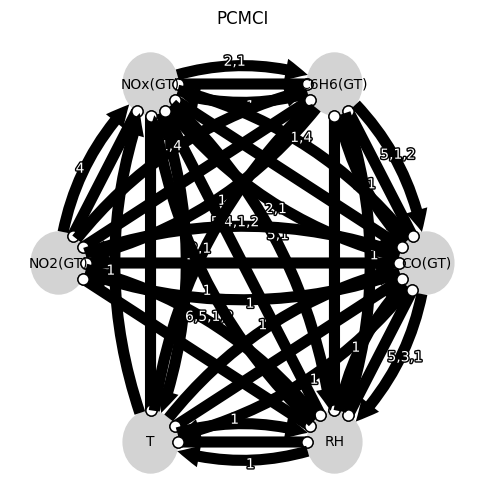

Matrice d’adjacence LiNGAM :
 [[ 0.00000000e+00  1.69124742e-01  0.00000000e+00  6.95846693e-03
  -3.41880975e-02  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.86404179e-01
   3.58886398e-01  8.66070216e-02]
 [ 3.17946281e+01  3.04407539e+00  0.00000000e+00  5.38414861e-01
  -2.30009154e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   3.77166372e+00  4.58015640e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -2.43422469e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


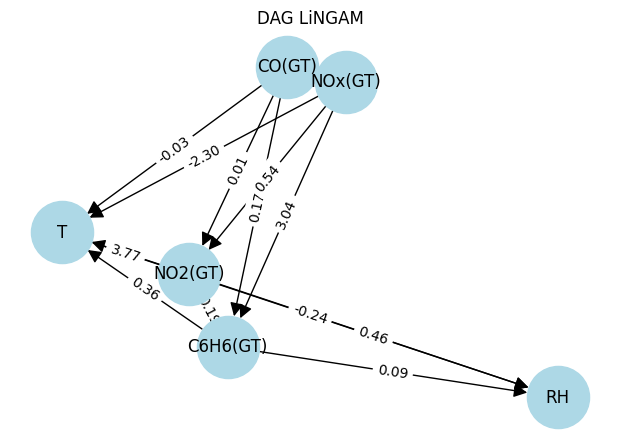

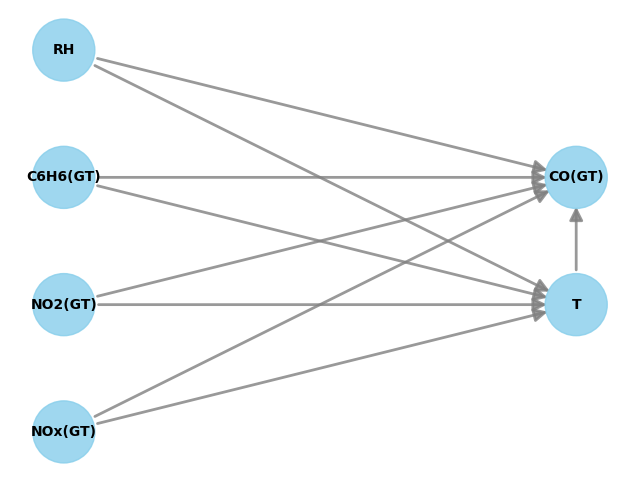

In [442]:


# Sélectionner un sous-ensemble de variables pour la découverte causale
subset = df[["CO(GT)","C6H6(GT)", "NOx(GT)","NO2(GT)","T", "RH"]].dropna()


# 1. PCMCI
pcmci_results, pcmci_graph = run_pcmci(subset, maxlag=6, alpha=0.05)
# 2. LiNGAM
lingam_adj = run_lingam(subset)

# 3. Exemple de SCM : définir traitement, résultat et covariables
scm = build_scm(subset, treatment="T", outcome="CO(GT)", common_causes=["C6H6(GT)", "NOx(GT)","NO2(GT)", "RH"])




In [443]:
%pip install econml scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [444]:
from econml.dml import CausalForestDML
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LassoCV
import pickle

# Sélectionner les variables en fonction des résultats de PCMCI/LiNGAM
features = [ "NOx(GT)", "NO2(GT)", "C6H6(GT)","T","RH"] #'CO(GT)','C6H6(GT)', 'NOx(GT)', 'NO2(GT)', 'T' 
treatment = "T"
outcome = "CO(GT)"

#X = subset[features].values
X = subset[features]#df[features]
T_var = subset[[treatment]].values#df[treatment]
Y = subset[outcome].values#df[outcome]

# --- Sauvegarder les noms de colonnes ---
with open("feature_names.pkl", "wb") as f:
    pickle.dump(X.columns.tolist(), f)

# Transformer les étiquettes de la variable cible en valeurs numériques 
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(Y)

# Appliquer une mise à l’échelle des variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Diviser les données en ensembles d'entraînement et de test
from sklearn.model_selection import train_test_split
X_train, X_test, T_train, T_test, Y_train, Y_test = train_test_split(X_scaled, T_var, y_encoded, test_size=0.2, random_state=42)#(X, T_var, Y, test_size=0.2, random_state=42)

In [445]:
# --- Sauvegarder les noms de colonnes ---
import pickle
#with open("feature_names.pkl", "wb") as f:
#    pickle.dump(X_train.columns.tolist(), f)

with open("feature_names.pkl", "rb") as f:
    feature_names = pickle.load(f)


print("Noms des variables utilisés dans Streamlit :", feature_names)

# --- Scaler ---
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.transform(X_test)

Noms des variables utilisés dans Streamlit : ['NOx(GT)', 'NO2(GT)', 'C6H6(GT)', 'T', 'RH']


In [446]:
import numpy as np
from econml.dml import CausalForestDML
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Créer et paramétrer le modèle de causal forest
causal_forest = CausalForestDML(
    model_t=RandomForestRegressor(),
    model_y=RandomForestRegressor(),
    discrete_treatment=False,
    cv=3,
    n_estimators=100,
    min_samples_leaf=10,
    random_state=42
)

# Entraîner (ajuster) le modèle sur les données d'entraînement 
causal_forest.fit(Y_train, T_train, X=X_train)#X=X_train)
#causal_forest.fit(Y_train, T_train, X=X_train_scaled)

# ---- 1. # Estimation de l’effet du traitement ----
# Effet moyen conditionnel du traitement (CATE)
cate_train = causal_forest.effect(X_train)
cate_test  = causal_forest.effect(X_test)
cate_pred = causal_forest.effect(X_test)
print("Mean CATE (effect of T on Y):", np.mean(cate_pred))

# Intervalle de confiance des effets
lb, ub = causal_forest.effect_interval(X_test)
print("IC 95 % pour le CATE (5 premières lignes):")
for i in range(5):
    print(f"Echantillon {i}: effet={cate_pred[i]:.4f}, IC=({lb[i]:.4f}, {ub[i]:.4f})")

# ---- 2. Effet moyen du traitement (ATE) ----
ate = causal_forest.ate(X_test)
ate_lb, ate_ub = causal_forest.ate_interval(X_test)
print(f"ATE: {ate:.4f}, 95% IC=({ate_lb:.4f}, {ate_ub:.4f})")


c:\Users\camar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\camar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\camar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Mean CATE (effect of T on Y): -0.49124908863429617
IC 95 % pour le CATE (5 premières lignes):
Echantillon 0: effet=-1.7256, IC=(-8.9426, 5.4914)
Echantillon 1: effet=-1.8910, IC=(-7.8345, 4.0524)
Echantillon 2: effet=-1.6054, IC=(-5.4258, 2.2150)
Echantillon 3: effet=3.3273, IC=(-3.0976, 9.7523)
Echantillon 4: effet=2.6965, IC=(-3.7421, 9.1350)
ATE: -0.4912, 95% IC=(-7.5659, 6.5834)


In [422]:
import pandas as pd

# Convert arrays to DataFrames first
#X_train_aug = pd.DataFrame(X_train, columns=feature_names)#[f"feature_{i}" for i in range(X_train.shape[1])])
#X_test_aug = pd.DataFrame(X_test, columns=feature_names)#[f"feature_{i}" for i in range(X_test.shape[1])])
X_train_aug = pd.DataFrame(X_train, columns=feature_names)  # feature_names que tu as sauvegardé
X_test_aug = pd.DataFrame(X_test, columns=feature_names)

# Add causal forest CATE estimates
X_train_aug["T"] = T_train
X_test_aug["T"]  = T_test

X_train_aug["CATE"] = cate_train
X_test_aug["CATE"] = cate_test

# Interaction utile : comment l'effet causal module l'effet de T
X_train_aug["T_x_cate"] = X_train_aug["T"] * X_train_aug["CATE"]
X_test_aug["T_x_cate"]  = X_test_aug["T"]  * X_test_aug["CATE"]

print("Forme des données d'entrainement augmentées:", X_train_aug.shape)
print("Forme des données de test augmentées:", X_test_aug.shape)


Forme des données d'entrainement augmentées: (661, 7)
Forme des données de test augmentées: (166, 7)


In [447]:
# ==============================================================================
# Modèle final : Causal Forest + Deep Learning
# ==============================================================================
import numpy as np
import pandas as pd
from econml.dml import CausalForestDML
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping


# ------------------------------------------------------------------------------
# 1: Entraîner Causal Forest
# ------------------------------------------------------------------------------

#causal_forest = CausalForestDML(
#    model_t=RandomForestRegressor(),
#    model_y=RandomForestRegressor(),
#    discrete_treatment=False,
#    cv=3,
#    n_estimators=100,
#    min_samples_leaf=10,
#    random_state=42
#)

# Entraîner le modèle sur l’ensemble d’apprentissage 
#causal_forest.fit(Y_train, T_train, X=X_train)
# Obtenir les effets du traitement
#cate_train = causal_forest.effect(X_train)
#cate_test = causal_forest.effect(X_test)

# ------------------------------------------------------------------------------
# 2: Augmenter les variables avec le CATE
# ------------------------------------------------------------------------------

# Convert X arrays to DataFrames with column names
#X_train_aug = pd.DataFrame(X_train, columns=feature_names)  #[f"feature_{i}" for i in range(X_train.shape[1])])
#X_test_aug = pd.DataFrame(X_test, columns=feature_names)  #[f"feature_{i}" for i in range(X_test.shape[1])])
#X_train_aug = pd.DataFrame(X_train, columns=feature_names)  # feature_names que tu as sauvegardé
#X_test_aug = pd.DataFrame(X_test, columns=feature_names)
# Add causal effect estimates as a new feature
#X_train_aug["CATE"] = cate_train
#X_test_aug["CATE"] = cate_test

#print("Forme des données d’entraînement augmentées:", X_train_aug.shape)
#print("Forme des données de test augmentées:", X_test_aug.shape)

# ------------------------------------------------------------------------------
# 3: Modèle de Deep Learning
# ------------------------------------------------------------------------------

# # Construire un réseau de neurones feedforward simple
dl_model = Sequential()
dl_model.add(Dense(64, activation='relu', input_shape=(X_train_aug.shape[1],)))#X_train_aug.shape[1]
dl_model.add(Dense(32, activation='relu'))
dl_model.add(Dense(1))  # Single output for outcome prediction
dl_model.compile(optimizer='adam', loss='mse')

# Early stopping pour éviter l’overfit
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entraîner le modèle sur les variables augmentées
history = dl_model.fit(
    X_train_aug, Y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[es],
    verbose=1
)

# ------------------------------------------------------------------------------
# 4: Évaluation du modèle
# ------------------------------------------------------------------------------

# Prédire sur l’ensemble de test
y_pred = dl_model.predict(X_test_aug)#X_test_aug

# Calcul des métriques d’évaluation du modèle
rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)

print(f"\nPerformance du modèle final:")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")


Epoch 1/50


c:\Users\camar\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 360.4466 - val_loss: 287.1945
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 270.1980 - val_loss: 195.3345
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 237.3910 - val_loss: 177.1821
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 208.7447 - val_loss: 153.2358
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 182.6321 - val_loss: 133.6648
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 158.3967 - val_loss: 114.4674
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 135.7500 - val_loss: 96.2375
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 112.4573 - val_loss: 81.7005
Epoch 9/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 90.5494 - val_loss: 67.9093
Epoch 10/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 75.3285 - val_loss: 63.1329
Epoch 11/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 62.8257 - val_loss: 41.8651
Epoch 12/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/st

In [448]:
import joblib
import pickle

# # Sauvegarder les modèles et les artefacts de prétraitement

dl_model.save("deep_model.keras")

# Utilisation d’un format hérité
dl_model.save("deep_model.h5")

# # Sauvegarder le modèle de Causal Forest
joblib.dump(causal_forest, "causal_forest.pkl")

# Sauvegarder le scaler et les noms des variables
joblib.dump(scaler, "scaler.pkl")



with open("feature_names.pkl", "wb") as f:
    pickle.dump(list(X_train_aug.columns), f)

print("Modèles et artefacts de prétraitement sauvegardés avec succès !")


Modèles et artefacts de prétraitement sauvegardés avec succès !
